In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cgs,fs
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
import os
import time
from multiprocessing import Pool
from multiprocessing import cpu_count
import contextlib

In [2]:
os.environ["OMP_NUM_THREADS"] = "32"

In [3]:
ncpu=cpu_count()
print("{0} CPUs".format(ncpu))

32 CPUs


In [4]:
dat=np.loadtxt("GRB160821B/lateX.txt")
x_obs1=dat[:,0]
tmp=dat[:,1]
tmp=dat[:,2]
y_obs1=dat[:,3]
yerr1=dat[:,4]
tmp=dat[:,5]
#x_obs1,tmp,tmp,y_obs1,yerr1,tmp=gread.readcol("GRB160821B/lateX.txt",twod=False)
x_obs1=np.log10(x_obs1)
yerr1=np.log10(1.+yerr1/y_obs1)
y_obs1=np.log10(y_obs1)

In [5]:
x_obs1

array([3.74415469, 4.09225414, 4.44220093, 4.73765531, 5.53223062,
       5.93546998])

In [6]:
dat[0:,1]

array([  1050.337,   4940.325,   2483.135, 147149.352,      0.   ,
            0.   ])

In [7]:
lgFX=fs.FS_flux(0.81,10**51., 100., 0.1, 0.01, 0.1, 2.3, 'X-ray', x_obs1)

In [8]:
lgFX

array([-7.40078184, -6.70458294, -6.00468936, -5.41378061, -3.82462999,
       -3.01815126])

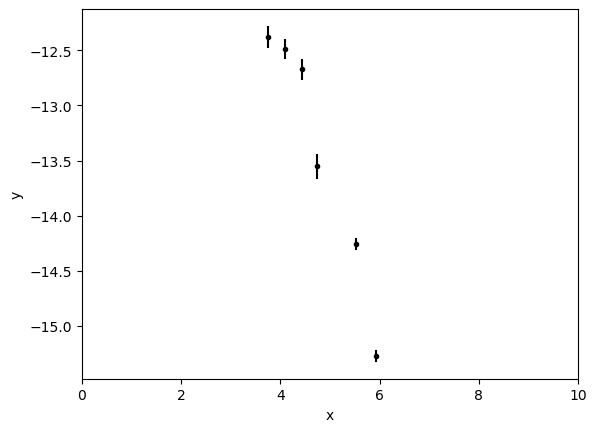

In [9]:
plt.errorbar(x_obs1, y_obs1, yerr=yerr1, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [10]:
def log_like(theta, x_obs, y_obs, yerr):
    E52, n18, epsilon_B = theta
    E52=10.**E52
    n18=10.**n18
    epsilon_B=10.**epsilon_B
    lgFX=fs.FS_flux(0.1613,E52, 51.5, n18, epsilon_B, 0.3, 2.24, 'X-ray', x_obs)
    chisq=(np.sum(((lgFX-y_obs)/(yerr))**2.0))
    return -0.5 * chisq


In [11]:
np.random.seed(42)
nll = lambda *args: -log_like(*args)
initial = np.array([1., 0., -2]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x_obs1, y_obs1, yerr1))
E52_ml, n18_ml, epsB_ml = soln.x

print("Maximum likelihood estimates:")
print("E52 = {0:.3f}".format(E52_ml))
print("n18 = {0:.3f}".format(n18_ml))
print("epsilon_B = {0:.3f}".format(epsB_ml))

Maximum likelihood estimates:
E52 = -1.236
n18 = -1.985
epsilon_B = -3.215


In [12]:
E52_ml

-1.235763574980624

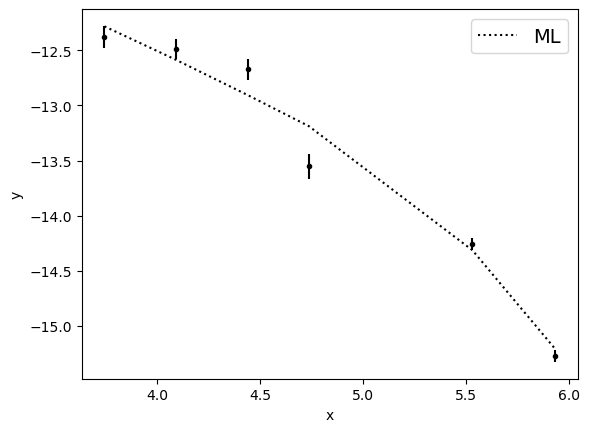

In [13]:
lgFitX=fs.FS_flux(0.1613,10**E52_ml, 51.5, 10**n18_ml, 10**epsB_ml, 0.3, 2.24, 'X-ray', x_obs1)

plt.errorbar(x_obs1, y_obs1, yerr=yerr1, fmt=".k", capsize=0)
plt.errorbar(x_obs1, lgFitX,fmt=":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [14]:
def log_prior(theta):
    lgE52, lgn18, lgepsB = theta
    if -2.0 < lgE52 <0. and -5.0 < lgn18 < 0.0 and -4.0 < lgepsB < -0.5:
        return 0.0
    return -np.inf

def log_prob(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y, yerr)

In [15]:

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

#with Pool() as pool:

#with contextlib.closing(Pool(processes=4)) as pool:
with contextlib.closing(Pool()) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_obs1, y_obs1, yerr1), pool=pool)
    start=time.time()
    sampler.run_mcmc(pos, 5000, progress=True);
    end=time.time()
    multi_time=end-start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_obs1, y_obs1, yerr1))
#sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [06:11<00:00, 13.45it/s]

Multiprocessing took 371.7 seconds


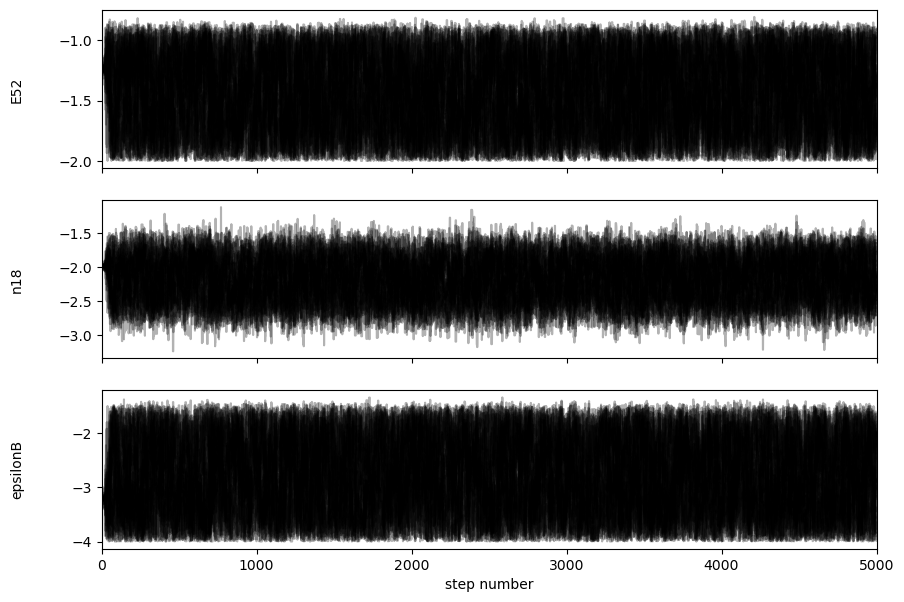

In [16]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["E52", "n18", "epsilonB"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

[45.99734528 43.65285055 45.62064292]
(10432, 3)


In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


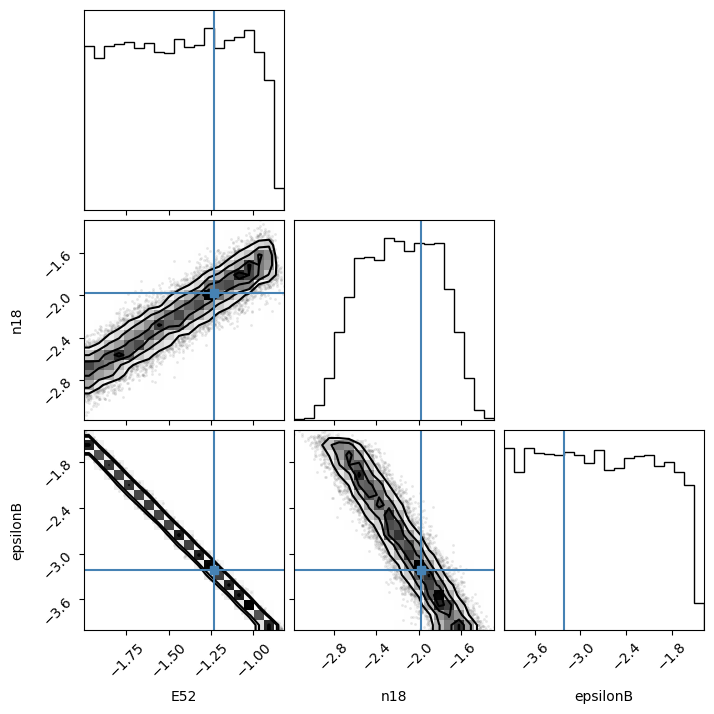

In [19]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[E52_ml, n18_ml, epsB_ml]
);

In [20]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
flat_samples[:,1]

array([-2.20989765, -2.39969816, -2.03871715, ..., -1.74543278,
       -1.88181327, -2.24924535])

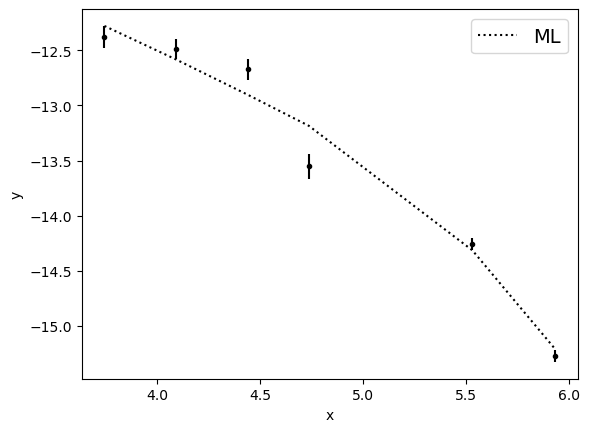

In [22]:
lgFitX=fs.FS_flux(0.1613,10**(-1.444), 51.5, 10**(-2.183), 10**(-2.752), 0.3, 2.24, 'X-ray', x_obs1)

plt.errorbar(x_obs1, y_obs1, yerr=yerr1, fmt=".k", capsize=0)
plt.errorbar(x_obs1, lgFitX,fmt=":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [2]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [41]:
np.random.randint(len(flat_samples), size=100)
flat_samples[4413]

array([-0.93481958, -1.65765485, -3.80523038])

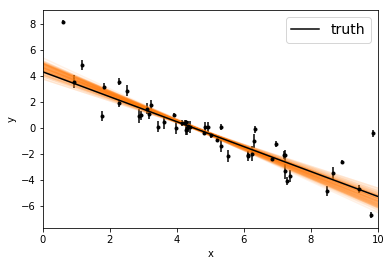

In [25]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [19]:
ndim

3